In [1]:
!pip install opendatasets --quiet

In [2]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from  skimage.transform import resize
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import pickle

import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import opendatasets as od
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
project_name='indian-sign-language'

In [4]:
# Dowload the dataset
# Execute this cell if you're running this in colab
dataset_url = "https://www.kaggle.com/vaishnaviasonawane/indian-sign-language-dataset"
od.download(dataset_url)

Skipping, found downloaded files in ".\indian-sign-language-dataset" (use force=True to force download)


In [4]:
training_dir="./indian-sign-language-dataset/data"
content=sorted(os.listdir(training_dir))
print(content)
len(content)

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


35

In [5]:
data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(training_dir, target_size=(200,200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="training")

validation_generator = data_generator.flow_from_directory(training_dir, target_size=(200, 200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="validation")

Found 37800 images belonging to 35 classes.
Found 4200 images belonging to 35 classes.


In [6]:
WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = keras.applications.inception_v3.InceptionV3(
    input_shape = (200, 200, 3), 
    include_top = False, 
    weights = 'imagenet'
)

inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 22, 22, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 22, 22, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 22, 22, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 22, 22, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 22, 22, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 22, 22, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 22, 22, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 22, 22, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 10, 10, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 10, 10, 128)  384        ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 10, 10, 128)  114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 10, 10, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 10, 10, 160)  179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 10, 10, 160)  480        ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 10, 10, 160)  0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 10, 10, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 10, 10, 160)  0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 10, 10, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 10, 10, 160)  179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 10, 10, 160)  480        ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 10, 10, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 10, 10, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 10, 10, 192)  576        ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 10, 10, 192)  576        ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 10, 10, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 10, 10, 192)  0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 10, 10, 192)  0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 4, 4, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 4, 4, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 4, 4, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 4, 4, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 4, 4, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 4, 4, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 4, 4, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 4, 4, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [7]:
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [8]:
from tensorflow.keras import layers
x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)                  
x = layers.Dense(35, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [9]:
LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.979

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

In [10]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=200,
    validation_steps=50,
    epochs=50,
    callbacks=[callback]
)

C:\Users\91926\AppData\Local\Temp\ipykernel_3916\3258626001.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.1417 - acc: 0.9747 
Reached 97.89999999999999 accuracy, Stopping!
200/200 [==============================] - 3140s 16s/step - loss: 0.1417 - acc: 0.9747 - val_loss: 1.0753e-04 - val_acc: 1.0000


In [11]:
model.save('transferlearning2.h5')

In [13]:
predictions = model.predict(validation_generator) # Make predictions towards the test set

66/66 [==============================] - 117s 2s/step


In [15]:
predict = pd.DataFrame(predictions)

In [18]:
predict.describe()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
count,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,...,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03,4.200000e+03
mean,2.857045e-02,2.857205e-02,2.856976e-02,2.857023e-02,2.856960e-02,2.857922e-02,2.857131e-02,2.857372e-02,2.857037e-02,2.857309e-02,...,2.857083e-02,2.857354e-02,2.856913e-02,2.857063e-02,2.856915e-02,2.856559e-02,2.856348e-02,2.857301e-02,2.857411e-02,2.856933e-02
std,1.666045e-01,1.665972e-01,1.665992e-01,1.666098e-01,1.665978e-01,1.666140e-01,1.666088e-01,1.666112e-01,1.665922e-01,1.666147e-01,...,1.665919e-01,1.666134e-01,1.665901e-01,1.665958e-01,1.665945e-01,1.665734e-01,1.665606e-01,1.666123e-01,1.666102e-01,1.665921e-01
min,6.744629e-10,1.511941e-09,1.281752e-09,1.561222e-09,3.577541e-09,6.962882e-09,7.611216e-10,1.140360e-08,1.400569e-08,4.652179e-09,...,7.767169e-09,7.523219e-09,2.804132e-09,2.333079e-09,7.618191e-09,3.050499e-09,4.976264e-09,5.035398e-09,1.595117e-08,3.009198e-09
25%,1.227350e-07,4.049882e-07,1.077958e-07,1.018503e-07,2.241155e-07,1.090913e-06,3.204141e-07,2.949745e-07,7.546477e-07,3.067657e-07,...,3.725144e-07,5.443834e-07,7.469876e-07,5.470026e-07,4.131412e-07,3.338797e-07,3.433978e-07,3.441430e-07,7.051843e-07,3.283949e-07
50%,4.955746e-07,1.059912e-06,3.589767e-07,3.638034e-07,7.001920e-07,3.461722e-06,8.888100e-07,1.124219e-06,1.783201e-06,8.518985e-07,...,1.160052e-06,1.328658e-06,1.773492e-06,1.591389e-06,9.665144e-07,8.447861e-07,9.187012e-07,8.857415e-07,1.956383e-06,8.595350e-07
75%,1.898658e-06,2.908715e-06,2.062634e-06,1.046575e-06,2.243562e-06,1.087481e-05,2.521116e-06,2.983980e-06,5.231679e-06,2.505184e-06,...,4.554769e-06,3.931242e-06,3.783773e-06,4.318021e-06,2.584767e-06,2.638244e-06,2.782145e-06,2.635270e-06,6.040759e-06,2.742123e-06
max,9.999763e-01,9.999810e-01,9.999856e-01,9.999892e-01,9.999524e-01,9.999964e-01,9.999850e-01,9.999861e-01,9.999875e-01,9.999939e-01,...,9.999461e-01,9.999915e-01,9.999845e-01,9.999650e-01,9.999572e-01,9.999523e-01,9.998773e-01,9.999890e-01,9.999948e-01,9.999763e-01


In [13]:
history

In [14]:
model

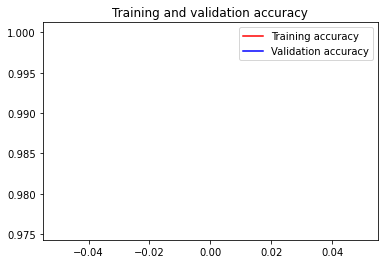

<Figure size 432x288 with 0 Axes>

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()



plt.show()


<Figure size 432x288 with 0 Axes>

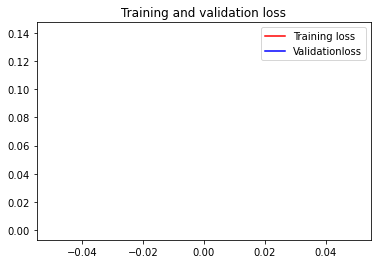

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validationloss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [174]:
df = pd.DataFrame(model(xtest))

In [175]:
df.to_csv('data.csv',index=False)

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
%matplotlib inline
import pathlib
import imageio


In [129]:
import os

loc1 = './indian-sign-language-dataset/data/1'
loc2 = './indian-sign-language-dataset/data/2'
loc3 = './indian-sign-language-dataset/data/3'
loc4 = './indian-sign-language-dataset/data/4'
loc5 = './indian-sign-language-dataset/data/5'
loc6 = './indian-sign-language-dataset/data/6'
loc7 = './indian-sign-language-dataset/data/7'
loc8 = './indian-sign-language-dataset/data/8'
loc9 = './indian-sign-language-dataset/data/9'
locA = './indian-sign-language-dataset/data/A'
locB = './indian-sign-language-dataset/data/B'
locC = './indian-sign-language-dataset/data/C'
locD = './indian-sign-language-dataset/data/D'
locE = './indian-sign-language-dataset/data/E'
locF = './indian-sign-language-dataset/data/F'
locG = './indian-sign-language-dataset/data/G'
locH = './indian-sign-language-dataset/data/H'
locI = './indian-sign-language-dataset/data/I'
locJ = './indian-sign-language-dataset/data/J'
locK = './indian-sign-language-dataset/data/K'
locL = './indian-sign-language-dataset/data/L'
locM = './indian-sign-language-dataset/data/M'
locN = './indian-sign-language-dataset/data/N'
locO = './indian-sign-language-dataset/data/O'
locP = './indian-sign-language-dataset/data/P'
locQ = './indian-sign-language-dataset/data/Q'
locR = './indian-sign-language-dataset/data/R'
locS = './indian-sign-language-dataset/data/S'
locT = './indian-sign-language-dataset/data/T'
locU = './indian-sign-language-dataset/data/U'
locV = './indian-sign-language-dataset/data/V'
locW = './indian-sign-language-dataset/data/W'
locX = './indian-sign-language-dataset/data/X'
locY = './indian-sign-language-dataset/data/Y'
locZ = './indian-sign-language-dataset/data/Z'

In [130]:
import cv2
from tqdm import tqdm

features = []

for img in tqdm(os.listdir(loc1)):
    f = cv2.imread(os.path.join(loc1,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(loc2)):
    f = cv2.imread(os.path.join(loc2,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(loc3)):
    f = cv2.imread(os.path.join(loc3,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(loc4)):
    f = cv2.imread(os.path.join(loc4,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(loc5)):
    f = cv2.imread(os.path.join(loc5,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(loc6)):
    f = cv2.imread(os.path.join(loc6,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(loc7)):
    f = cv2.imread(os.path.join(loc7,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(loc8)):
    f = cv2.imread(os.path.join(loc8,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(loc9)):
    f = cv2.imread(os.path.join(loc9,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locA)):
    f = cv2.imread(os.path.join(locA,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locB)):
    f = cv2.imread(os.path.join(locB,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locC)):
    f = cv2.imread(os.path.join(locC,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locD)):
    f = cv2.imread(os.path.join(locD,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locE)):
    f = cv2.imread(os.path.join(locE,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locF)):
    f = cv2.imread(os.path.join(locF,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locG)):
    f = cv2.imread(os.path.join(locG,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locH)):
    f = cv2.imread(os.path.join(locH,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locI)):
    f = cv2.imread(os.path.join(locI,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)

for img in tqdm(os.listdir(locJ)):
    f = cv2.imread(os.path.join(locJ,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locK)):
    f = cv2.imread(os.path.join(locK,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locL)):
    f = cv2.imread(os.path.join(locL,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locM)):
    f = cv2.imread(os.path.join(locM,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locN)):
    f = cv2.imread(os.path.join(locN,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locO)):
    f = cv2.imread(os.path.join(locO,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locP)):
    f = cv2.imread(os.path.join(locP,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locQ)):
    f = cv2.imread(os.path.join(locQ,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locR)):
    f = cv2.imread(os.path.join(locR,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)

for img in tqdm(os.listdir(locS)):
    f = cv2.imread(os.path.join(locS,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locT)):
    f = cv2.imread(os.path.join(locT,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locU)):
    f = cv2.imread(os.path.join(locU,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locV)):
    f = cv2.imread(os.path.join(locV,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locW)):
    f = cv2.imread(os.path.join(locW,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)        #convert colored images into grayscale format
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locX)):
    f = cv2.imread(os.path.join(locX,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locY)):
    f = cv2.imread(os.path.join(locY,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)
    
for img in tqdm(os.listdir(locZ)):
    f = cv2.imread(os.path.join(locZ,img))
    f = cv2.cvtColor(f , cv2.COLOR_BGR2GRAY)
    f = cv2.resize(f , (50,50))
    features.append(f)

100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:01<00:00, 627.95it/s]


In [131]:
labels = []

for img in tqdm(os.listdir(loc1)):
    labels.append(1)
    
for img in tqdm(os.listdir(loc2)):
    labels.append(2)
    
for img in tqdm(os.listdir(loc3)):
    labels.append(3)
    
for img in tqdm(os.listdir(loc4)):
    labels.append(4)
    
for img in tqdm(os.listdir(loc5)):
    labels.append(5)
    
for img in tqdm(os.listdir(loc6)):
    labels.append(6)
    
for img in tqdm(os.listdir(loc7)):
    labels.append(7)
    
for img in tqdm(os.listdir(loc8)):
    labels.append(8)
    
for img in tqdm(os.listdir(loc9)):
    labels.append(9)
    
for img in tqdm(os.listdir(locA)):
    labels.append(10)
    
for img in tqdm(os.listdir(locB)):
    labels.append(11)
    
for img in tqdm(os.listdir(locC)):
    labels.append(12)
    
for img in tqdm(os.listdir(locD)):
    labels.append(13)
    
for img in tqdm(os.listdir(locE)):
    labels.append(14)
    
for img in tqdm(os.listdir(locF)):
    labels.append(15)
    
for img in tqdm(os.listdir(locG)):
    labels.append(16)
    
for img in tqdm(os.listdir(locH)):
    labels.append(17)
    
for img in tqdm(os.listdir(locI)):
    labels.append(18)

for img in tqdm(os.listdir(locJ)):
    labels.append(19)
    
for img in tqdm(os.listdir(locK)):
    labels.append(20)
    
for img in tqdm(os.listdir(locL)):
    labels.append(21)
    
for img in tqdm(os.listdir(locM)):
    labels.append(22)
    
for img in tqdm(os.listdir(locN)):
    labels.append(23)
    
for img in tqdm(os.listdir(locO)):
    labels.append(24)
    
for img in tqdm(os.listdir(locP)):
    labels.append(25)
    
for img in tqdm(os.listdir(locQ)):
    labels.append(26)
    
for img in tqdm(os.listdir(locR)):
    labels.append(27)
    
for img in tqdm(os.listdir(locS)):
    labels.append(28)
    
for img in tqdm(os.listdir(locT)):
    labels.append(29)
    
for img in tqdm(os.listdir(locU)):
    labels.append(30)
    
for img in tqdm(os.listdir(locV)):
    labels.append(31)
    
for img in tqdm(os.listdir(locW)):
    labels.append(32)
    
for img in tqdm(os.listdir(locX)):
    labels.append(33)
    
for img in tqdm(os.listdir(locY)):
    labels.append(34)
    
for img in tqdm(os.listdir(locZ)):
    labels.append(35)

100%|█████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 1201519.41it/s]


In [132]:
import numpy as np

X = np.array(features)
print(X.shape)

Y = np.array(labels)
print(Y.shape)

(42000, 50, 50)
(42000,)


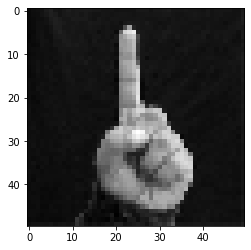

In [133]:
import matplotlib.pyplot as plt
plt.imshow(X[678] , cmap='gray')
plt.show()

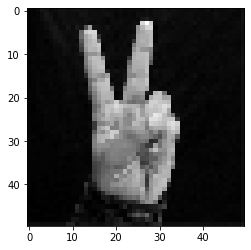

In [134]:
import matplotlib.pyplot as plt
plt.imshow(X[1778] , cmap='gray')
plt.show()

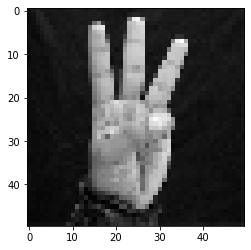

In [135]:
import matplotlib.pyplot as plt
plt.imshow(X[2778] , cmap='gray')
plt.show()

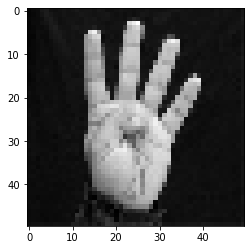

In [136]:
import matplotlib.pyplot as plt
plt.imshow(X[3778] , cmap='gray')
plt.show()

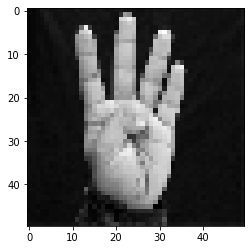

In [137]:
import matplotlib.pyplot as plt
plt.imshow(X[4778] , cmap='gray')
plt.show()

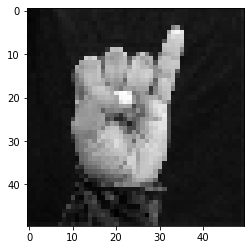

In [138]:
import matplotlib.pyplot as plt
plt.imshow(X[6778] , cmap='gray')
plt.show()

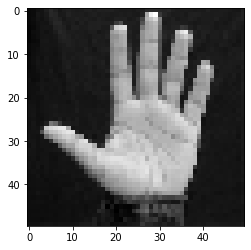

In [139]:
import matplotlib.pyplot as plt
plt.imshow(X[5778] , cmap='gray')
plt.show()

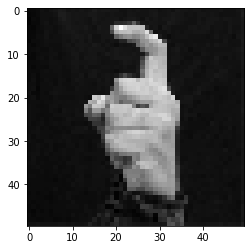

In [140]:
import matplotlib.pyplot as plt
plt.imshow(X[7778] , cmap='gray')
plt.show()


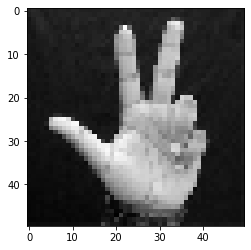

In [141]:
import matplotlib.pyplot as plt
plt.imshow(X[8778] , cmap='gray')
plt.show()

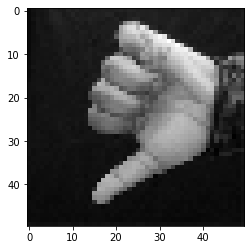

In [142]:
import matplotlib.pyplot as plt
plt.imshow(X[9778] , cmap='gray')
plt.show()

In [151]:
import keras
from keras.utils import np_utils

X = X.reshape(42000,2500)
X = np_utils.normalize(X)

Y = np_utils.to_categorical(Y)

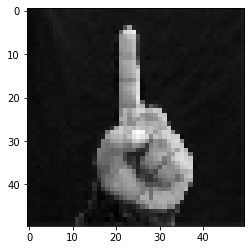

In [153]:
plt.imshow(X[678].reshape(50,50) , cmap='gray')
plt.show()

In [154]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.9)

In [155]:
from keras import models
from keras import layers

In [166]:
model = models.Sequential()

model.add(layers.Dense(64 , activation='relu' , input_dim=2500))
model.add(layers.Dense(32 , activation='relu'))
model.add(layers.Dense(10 , activation='sigmoid'))

In [167]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 64)                160064    
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 10)                330       
                                                                 
Total params: 162,474
Trainable params: 162,474
Non-trainable params: 0
_________________________________________________________________


In [168]:
import tensorflow as tf

sgd = tf.keras.optimizers.SGD(learning_rate = 0.1)
model.compile(optimizer='sgd' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [169]:
model.fit(xtrain,ytrain,epochs=20, validation_data=(xtest,ytest))

Epoch 1/20


ValueError: in user code:

    File "C:\Users\91926\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\91926\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\91926\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\91926\anaconda3\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\91926\anaconda3\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "C:\Users\91926\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\91926\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\91926\anaconda3\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\91926\anaconda3\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\91926\anaconda3\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 36, 2, 2) and (None, 10) are incompatible


In [116]:
np.size(xtest)

2700000

In [125]:
df = pd.DataFrame(model.predict(xtest))

34/34 [==============================] - 0s 2ms/step


In [127]:
df.to_csv('score.csv',index=False)

In [119]:
score = model.predict(xtest)
np.sum(score)/np.size(xtest) * 100

34/34 [==============================] - 0s 2ms/step


0.20703114149305557

In [160]:
xtrain.shape

(37800, 2500)

In [161]:
ytrain.shape

(37800, 36, 2, 2)

In [162]:
xtest.shape

(4200, 2500)

In [163]:
ytest.shape

(4200, 36, 2, 2)